In [107]:
# -*- coding: utf-8 -*-

import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
plt.close('all')
import hatyan
import kenmerkendewaarden as kw # pip install git+https://github.com/Deltares-research/kenmerkendewaarden

# set logging level to INFO to get log messages
import logging
logging.basicConfig() # calling basicConfig is essential to set logging level for sub-modules
logging.getLogger("kenmerkendewaarden").setLevel(level="INFO")

# TODO: HW/LW numbers not always increasing (at havengetallen): ['HANSWT','BROUWHVSGT08','PETTZD','DORDT']

tstart_dt = pd.Timestamp(2011,1,1, tz="UTC+01:00")
tstop_dt = pd.Timestamp(2021,1,1, tz="UTC+01:00")
if ((tstop_dt.year-tstart_dt.year)==10) & (tstop_dt.month==tstop_dt.day==tstart_dt.month==tstart_dt.day==1):
    year_slotgem = tstop_dt.year
else:
    year_slotgem = 'invalid'
print(f'year_slotgem: {year_slotgem}')

# dir_base = r'p:\11208031-010-kenmerkende-waarden-k\work'
dir_base = r'p:\11210325-005-kenmerkende-waarden\work'
dir_meas = os.path.join(dir_base,'measurements_wl_18700101_20240101')
# TODO: move to full data folder (otherwise overschrijding and slotgemiddelde is completely wrong)
# dir_meas = os.path.join(dir_base,'measurements_wl_20101201_20220201')

dir_indicators = os.path.join(dir_base,f'out_tidalindicators_{year_slotgem}')
dir_slotgem = os.path.join(dir_base,f'out_slotgem_{year_slotgem}')
dir_havget = os.path.join(dir_base,f'out_havengetallen_{year_slotgem}')
dir_gemgetij = os.path.join(dir_base,f'out_gemgetij_{year_slotgem}')
dir_overschrijding = os.path.join(dir_base,f'out_overschrijding_{year_slotgem}')
os.makedirs(dir_indicators, exist_ok=True)
os.makedirs(dir_slotgem, exist_ok=True)
os.makedirs(dir_havget, exist_ok=True)
os.makedirs(dir_gemgetij, exist_ok=True)
os.makedirs(dir_overschrijding, exist_ok=True)

fig_alltimes_ext = [dt.datetime.strptime(x,'%Y%m%d') for x in os.path.basename(dir_meas).split('_')[2:4]]

# all stations from TK (dataTKdia)
station_list = ['A12','AWGPFM','BAALHK','BATH','BERGSDSWT','BROUWHVSGT02','BROUWHVSGT08','GATVBSLE','BRESKVHVN','CADZD',
                'D15','DELFZL','DENHDR','EEMSHVN','EURPFM','F16','F3PFM','HARVT10','HANSWT','HARLGN','HOEKVHLD','HOLWD','HUIBGT',
                'IJMDBTHVN','IJMDSMPL','J6','K13APFM','K14PFM','KATSBTN','KORNWDZBTN','KRAMMSZWT','L9PFM','LAUWOG','LICHTELGRE',
                'MARLGT','NES','NIEUWSTZL','NORTHCMRT','DENOVBTN','OOSTSDE04','OOSTSDE11','OOSTSDE14','OUDSD','OVLVHWT','Q1',
                'ROOMPBNN','ROOMPBTN','SCHAARVDND','SCHEVNGN','SCHIERMNOG','SINTANLHVSGR','STAVNSE','STELLDBTN','TERNZN','TERSLNZE','TEXNZE',
                'VLAKTVDRN','VLIELHVN','VLISSGN','WALSODN','WESTKPLE','WESTTSLG','WIERMGDN','YERSKE']
station_list = ["VLISSGN","HOEKVHLD","IJMDBTHVN","HARLGN","DENHDR","DELFZL","SCHIERMNOG","VLIELHVN","STELLDBTN","SCHEVNGN","ROOMPBTN"] # subset of 11 stations along the coast
# TODO: maybe add from Dillingh 2013: DORDT, MAASMSMPL, PETTZD, ROTTDM
station_list = ["VLISSGN","HOEKVHLD","HARLGN","DENHDR","DELFZL","SCHIERMNOG","VLIELHVN","SCHEVNGN","ROOMPBTN"] 
station_list = ["VLISSGN"]

nap_correction = False

compute_indicators = False
compute_slotgem = False
compute_havengetallen = False
compute_gemgetij = False
compute_overschrijding = True


for current_station in station_list:
    print(f'starting process for {current_station}')
    plt.close('all')
    
    # timeseries are used for slotgemiddelden, gemgetijkrommen (needs slotgem+havget)
    data_pd_meas_all = kw.read_measurements(dir_output=dir_meas, station=current_station, extremes=False, nap_correction=nap_correction)
    if data_pd_meas_all is not None:
        #crop measurement data
        data_pd_meas_10y = hatyan.crop_timeseries(data_pd_meas_all, times=slice(tstart_dt,tstop_dt-dt.timedelta(minutes=10)))#,onlyfull=False)
    
    # extremes are used for slotgemiddelden, havengetallen, overschrijding
    data_pd_HWLW_all = kw.read_measurements(dir_output=dir_meas, station=current_station, extremes=True, nap_correction=nap_correction)
    if data_pd_HWLW_all is not None:
        # TODO: make calc_HWLW12345to12() faster: https://github.com/Deltares/hatyan/issues/311
        data_pd_HWLW_all_12 = hatyan.calc_HWLW12345to12(data_pd_HWLW_all) #convert 12345 to 12 by taking minimum of 345 as 2 (laagste laagwater)
        #crop timeseries to 10y
        data_pd_HWLW_10y_12 = hatyan.crop_timeseries(data_pd_HWLW_all_12, times=slice(tstart_dt,tstop_dt),onlyfull=False)
    
    
    
    

year_slotgem: 2021


INFO:kenmerkendewaarden.data_retrieve:loading VLISSGN_measwl.nc


starting process for VLISSGN


In [3]:

    #### TIDAL INDICATORS
    if compute_indicators and data_pd_meas_all is not None and data_pd_HWLW_all is not None:
        print(f'tidal indicators for {current_station}')
        # compute and plot tidal indicators
        dict_wltidalindicators = kw.calc_wltidalindicators(data_pd_meas_all, min_coverage=1)
        dict_HWLWtidalindicators = kw.calc_HWLWtidalindicators(data_pd_HWLW_all_12, min_coverage=1)
        
        # add hat/lat
        df_meas_19y = data_pd_meas_all.loc["2001":"2019"]
        hat, lat = kw.calc_hat_lat_frommeasurements(df_meas_19y)
        dict_HWLWtidalindicators["hat"] = hat
        dict_HWLWtidalindicators["lat"] = lat
        
        # merge dictionaries
        dict_wltidalindicators.update(dict_HWLWtidalindicators)
        
        # plot
        fig, ax = kw.plot_tidalindicators(dict_wltidalindicators)
        fig.savefig(os.path.join(dir_indicators,f'tidal_indicators_{current_station}'))
    
    
    
    
    #### SLOTGEMIDDELDEN
    # TODO: nodal cycle is not in same phase for all stations, this is not physically correct.
    # TODO: more data is needed for proper working of fitting for some stations (2011: BAALHK, BRESKVHVN, GATVBSLE, SCHAARVDND)
    if compute_slotgem and data_pd_meas_all is not None and data_pd_HWLW_all is not None:
        print(f'slotgemiddelden for {current_station}')
                
        # compute slotgemiddelden, exclude all values after tstop_dt (is year_slotgem)
        # including years with too little values and years before physical break
        slotgemiddelden_all = kw.calc_slotgemiddelden(df_meas=data_pd_meas_all.loc[:tstop_dt], 
                                                      df_ext=data_pd_HWLW_all_12.loc[:tstop_dt], 
                                                      min_coverage=0, clip_physical_break=True)
        # only years with enough values and after potential physical break
        slotgemiddelden_valid = kw.calc_slotgemiddelden(df_meas=data_pd_meas_all.loc[:tstop_dt], 
                                                        df_ext=data_pd_HWLW_all_12.loc[:tstop_dt], 
                                                        min_coverage=1, clip_physical_break=True)
        
        # plot slotgemiddelden
        fig1, ax1 = kw.plot_slotgemiddelden(slotgemiddelden_valid, slotgemiddelden_all)
        ax1.set_xlim(fig_alltimes_ext)

        # plot and write slotgemiddelde value (for waterlevels only)
        slotgem_time_value = slotgemiddelden_valid["wl_model_fit"].iloc[[-1]]
        ax1.plot(slotgem_time_value, ".k", label=f'slotgemiddelde for {year_slotgem}')
        # TODO: is upcasted to dataframe before csv writing which results in 0-column, avoid this
        slotgem_time_value.to_csv(os.path.join(dir_slotgem,f'slotgem_value_{current_station}.txt'))
        
        # get and plot validation timeseries (yearly mean wl/HW/LW)
        station_name_dict = {'HOEKVHLD':'hoek',
                             'HARVT10':'ha10'}
        if current_station in station_name_dict.keys():
            dir_meas_gemHWLWwlAB = r'p:\archivedprojects\11208031-010-kenmerkende-waarden-k\work\data_KW-RMM'
            file_yearmeanHW = os.path.join(dir_meas_gemHWLWwlAB,f'{station_name_dict[current_station]}_hw.txt')
            file_yearmeanLW = os.path.join(dir_meas_gemHWLWwlAB,f'{station_name_dict[current_station]}_lw.txt')
            file_yearmeanwl = os.path.join(dir_meas_gemHWLWwlAB,f'{station_name_dict[current_station]}_Z.txt')
            yearmeanHW = pd.read_csv(file_yearmeanHW, sep='\\s+', skiprows=1, names=['datetime','values'], parse_dates=['datetime'], na_values=-999.9, index_col='datetime')/100
            yearmeanLW = pd.read_csv(file_yearmeanLW, sep='\\s+', skiprows=1, names=['datetime','values'], parse_dates=['datetime'], na_values=-999.9, index_col='datetime')/100
            yearmeanwl = pd.read_csv(file_yearmeanwl, sep='\\s+', skiprows=1, names=['datetime','values'], parse_dates=['datetime'], na_values=-999.9, index_col='datetime')/100
            ax1.plot(yearmeanHW['values'],'+g', zorder=0)
            ax1.plot(yearmeanLW['values'],'+g', zorder=0)
            ax1.plot(yearmeanwl['values'],'+g',label='yearmean validation', zorder=0)
            ax1.legend(loc=2)
        
        fig1.savefig(os.path.join(dir_slotgem,f'yearly_values_{current_station}'))
    
    
    
    
    ### HAVENGETALLEN 
    if compute_havengetallen and data_pd_HWLW_all is not None:
        
        df_havengetallen, data_pd_HWLW = kw.calc_havengetallen(df_ext=data_pd_HWLW_10y_12, return_df_ext=True)
        
        print(f'havengetallen for {current_station}')
        # plot hwlw per timeclass including median
        fig, axs = kw.plot_HWLW_pertimeclass(data_pd_HWLW, df_havengetallen)
        fig.savefig(os.path.join(dir_havget,f'HWLW_pertijdsklasse_inclmedianline_{current_station}'))
        
        # plot aardappelgrafiek
        fig, (ax1,ax2) = kw.plot_aardappelgrafiek(df_havengetallen)
        fig.savefig(os.path.join(dir_havget, f'aardappelgrafiek_{year_slotgem}_{current_station}'))
        
        #write to csv # TODO: do we need this in this format?
        HWLW_culmhr_summary_exp = df_havengetallen.loc[[6,'mean',0]] #select neap/mean/springtide
        HWLW_culmhr_summary_exp.index = ['neap','mean','spring']
        HWLW_culmhr_summary_exp.to_csv(os.path.join(dir_havget, f'havengetallen_{year_slotgem}_{current_station}.csv'),float_format='%.3f')
    
    
    
    
    ##### GEMIDDELDE GETIJKROMMEN
    if compute_gemgetij and data_pd_meas_all is not None and data_pd_HWLW_all is not None:
        
        print(f'gemiddelde getijkrommen for {current_station}')
        pred_freq = "10s" # frequency influences the accuracy of havengetallen-scaling and is writing frequency of BOI timeseries
        
        # derive getijkrommes: raw, scaled to havengetallen, scaled to havengetallen and 12h25min period
        gemgetij_raw = kw.calc_gemiddeldgetij(df_meas=data_pd_meas_10y, df_ext=None,
                                              freq=pred_freq, nb=0, nf=0, 
                                              scale_extremes=False, scale_period=False)
        gemgetij_corr = kw.calc_gemiddeldgetij(df_meas=data_pd_meas_10y, df_ext=data_pd_HWLW_10y_12,
                                               freq=pred_freq, nb=1, nf=1, 
                                               scale_extremes=True, scale_period=False)
        gemgetij_corr_boi = kw.calc_gemiddeldgetij(df_meas=data_pd_meas_10y, df_ext=data_pd_HWLW_10y_12,
                                                   freq=pred_freq, nb=0, nf=4, 
                                                   scale_extremes=True, scale_period=True)

        # write boi timeseries to csv files # TODO: maybe convert timedeltaIndex to minutes instead?
        for key in gemgetij_corr_boi.keys():
            file_boi_csv = os.path.join(dir_gemgetij, f'Getijkromme_BOI_{key}_{current_station}_slotgem{year_slotgem}.csv')
            gemgetij_corr_boi[key].to_csv(file_boi_csv, float_format='%.3f')
        
        fig_sum, ax_sum = kw.plot_gemiddeldgetij(gemgetij_dict=gemgetij_corr, gemgetij_dict_raw=gemgetij_raw, tick_hours=6)
        fig_sum.savefig(os.path.join(dir_gemgetij,f'gemgetij_trefHW_{current_station}'))
        
        # plot BOI figure and compare to KW2020
        fig_boi, ax1_boi = kw.plot_gemiddeldgetij(gemgetij_dict=gemgetij_corr_boi, tick_hours=12)
        
        # plot validation lines if available
        # TODO: these index of this line is converted from datetimes to timedeltas to get it in the same plot
        # TODO: the validation tidal signals are not 12h25m, which is incorrect in case of BOI. We can still compare the shape a bit
        dir_vali_krommen = r'p:\archivedprojects\11205258-005-kpp2020_rmm-g5\C_Work\00_KenmerkendeWaarden\07_Figuren\figures_ppSCL_2\final20201211'
        file_vali_doodtijkromme = os.path.join(dir_vali_krommen,f'doodtijkromme_{current_station}_havengetallen{year_slotgem}.csv')
        file_vali_gemtijkromme = os.path.join(dir_vali_krommen,f'gemGetijkromme_{current_station}_havengetallen{year_slotgem}.csv')
        file_vali_springtijkromme = os.path.join(dir_vali_krommen,f'springtijkromme_{current_station}_havengetallen{year_slotgem}.csv')        
        cmap = plt.get_cmap("tab10")
        if os.path.exists(file_vali_gemtijkromme):
            data_vali_gemtij = pd.read_csv(file_vali_gemtijkromme,index_col=0,parse_dates=True)
            data_vali_gemtij.index = data_vali_gemtij.index - data_vali_gemtij.index[0]
            ax1_boi.plot(data_vali_gemtij['Water Level [m]'],'--',color=cmap(0),linewidth=0.7,label='validation KW2020 gemtij')
        if os.path.exists(file_vali_springtijkromme):
            data_vali_springtij = pd.read_csv(file_vali_springtijkromme,index_col=0,parse_dates=True)
            data_vali_springtij.index = data_vali_springtij.index - data_vali_springtij.index[0]
            ax1_boi.plot(data_vali_springtij['Water Level [m]'],'--',color=cmap(1),linewidth=0.7,label='validation KW2020 springtij')
        if os.path.exists(file_vali_doodtijkromme):
            data_vali_doodtij = pd.read_csv(file_vali_doodtijkromme,index_col=0,parse_dates=True)
            data_vali_doodtij.index = data_vali_doodtij.index - data_vali_doodtij.index[0]
            ax1_boi.plot(data_vali_doodtij['Water Level [m]'],'--',color=cmap(2),linewidth=0.7, label='validation KW2020 doodtij')
        ax1_boi.legend(loc=4)
        
        fig_boi.savefig(os.path.join(dir_gemgetij,f'gemspringdoodtijkromme_BOI_{current_station}_slotgem{year_slotgem}.png'))
    
    

In [77]:
    ###OVERSCHRIJDINGSFREQUENTIES
    # TODO: SLR trend correctie voor overschrijdingsfrequenties en evt ook voor andere KW?
    # TODO: resulting freqs seem to be shifted w.r.t. getijtafelboekje (mail PH 9-3-2022)
    # plots beoordelen: rode lijn moet ongeveer verlengde zijn van groene, als die ineens omhoog piekt komt dat door hele extreme waardes die je dan vermoedelijk ook al ziet in je groene lijn
    
    Tfreqs_interested = [5, 2, 1, 1/2, 1/5, 1/10, 1/20, 1/50, 1/100, 1/200,
                         1/500, 1/1000, 1/2000, 1/4000, 1/5000, 1/10000]
    
    if compute_overschrijding and data_pd_HWLW_all is not None:
        print(f'overschrijdingsfrequenties for {current_station}')
        
        # only include data up to year_slotgem
        data_pd_measext = data_pd_HWLW_all_12.loc[:tstop_dt]
        
        #get Hydra-NL and KWK-RMM validation data (only for HOEKVHLD)
        dist_vali_exc = {}
        dist_vali_dec = {}
        if current_station =='HOEKVHLD':
            dir_vali_overschr = os.path.join(dir_base,'data_overschrijding') # TODO: this data is not reproducible yet
            stat_name = 'Hoek_van_Holland'
            dist_vali_exc = {}
            dist_vali_exc['Hydra-NL'] = pd.read_csv(os.path.join(dir_vali_overschr,'Processed_HydraNL','Without_model_uncertainty',f'{stat_name}.csv'), sep=';', header=[0])
            dist_vali_exc['Hydra-NL']['values'] /= 100 # cm to m
            dist_vali_exc['Hydra-NL met modelonzekerheid'] = pd.read_csv(os.path.join(dir_vali_overschr,'Processed_HydraNL','With_model_uncertainty',f'{stat_name}_with_model_uncertainty.csv'), sep=';', header=[0])
            dist_vali_exc['Hydra-NL met modelonzekerheid']['values'] /= 100 # cm to m
            file_vali_exeed = os.path.join(dir_vali_overschr,'Tables','Exceedance_lines',f'Exceedance_lines_{stat_name}.csv')
            if os.path.exists(file_vali_exeed):
                dist_vali_exc['validation'] = pd.read_csv(file_vali_exeed,sep=';')
                dist_vali_exc['validation']['values'] /= 100
            file_vali_dec = os.path.join(dir_vali_overschr,'Tables','Deceedance_lines',f'Deceedance_lines_{stat_name}.csv')
            if os.path.exists(file_vali_dec):
                dist_vali_dec['validation'] = pd.read_csv(file_vali_dec,sep=';')
                dist_vali_dec['validation']['values'] /= 100

overschrijdingsfrequenties for HOEKVHLD


In [97]:
    ###OVERSCHRIJDINGSFREQUENTIES
    # TODO: SLR trend correctie voor overschrijdingsfrequenties en evt ook voor andere KW?
    # TODO: resulting freqs seem to be shifted w.r.t. getijtafelboekje (mail PH 9-3-2022)
    # plots beoordelen: rode lijn moet ongeveer verlengde zijn van groene, als die ineens omhoog piekt komt dat door hele extreme waardes die je dan vermoedelijk ook al ziet in je groene lijn
    
    Tfreqs_interested = [5, 2, 1, 1/2, 1/5, 1/10, 1/20, 1/50, 1/100, 1/200,
                         1/500, 1/1000, 1/2000, 1/4000, 1/5000, 1/10000]
    
    if compute_overschrijding and data_pd_HWLW_all is not None:
        print(f'overschrijdingsfrequenties for {current_station}')
        
        # only include data up to year_slotgem
        data_pd_measext = data_pd_HWLW_all_12.loc[:tstop_dt]
        
        #get Hydra-NL and KWK-RMM validation data (only for HOEKVHLD)
        dist_vali_exc = {}
        dist_vali_dec = {}
        dir_vali_overschr = os.path.join(dir_base,'data_overschrijding') # TODO: this data is not reproducible yet

        if current_station =='HOEKVHLD':
            stat_name = 'Hoek_van_Holland'

            def set_table(dict, key, path):
                if os.path.exists(path):
                    dict[key] =pd.read_csv(path, sep=';')
                    dict[key]['values'] /= 100 
                return  

            hydra_nl_nouncertainty = os.path.join(dir_vali_overschr,'Processed_HydraNL','Without_model_uncertainty',f'{stat_name}.csv')
            hydra_nl_uncertainty = os.path.join(dir_vali_overschr,'Processed_HydraNL','With_model_uncertainty',f'{stat_name}_with_model_uncertainty.csv')
            file_validation_exeedance = os.path.join(dir_vali_overschr,'Tables','Exceedance_lines',f'Exceedance_lines_{stat_name}.csv')
            file_validation_deceedance = os.path.join(dir_vali_overschr,'Tables','Deceedance_lines',f'Deceedance_lines_{stat_name}.csv')

            set_table(dist_vali_exc, 'Hydra-NL', hydra_nl_nouncertainty)
            set_table(dist_vali_exc,'Hydra-NL met modelonzekerheid', hydra_nl_uncertainty)
            set_table(dist_vali_exc, 'validation', file_validation_exeedance)
            set_table(dist_vali_dec,'validation', file_validation_deceedance)

overschrijdingsfrequenties for HOEKVHLD


In [105]:
    ###OVERSCHRIJDINGSFREQUENTIES
    # TODO: SLR trend correctie voor overschrijdingsfrequenties en evt ook voor andere KW?
    # TODO: resulting freqs seem to be shifted w.r.t. getijtafelboekje (mail PH 9-3-2022)
    # plots beoordelen: rode lijn moet ongeveer verlengde zijn van groene, als die ineens omhoog piekt komt dat door hele extreme waardes die je dan vermoedelijk ook al ziet in je groene lijn
    
    Tfreqs_interested = [5, 2, 1, 1/2, 1/5, 1/10, 1/20, 1/50, 1/100, 1/200,
                         1/500, 1/1000, 1/2000, 1/4000, 1/5000, 1/10000]
    
    if compute_overschrijding and data_pd_HWLW_all is not None:
        print(f'overschrijdingsfrequenties for {current_station}')
        
        # only include data up to year_slotgem
        data_pd_measext = data_pd_HWLW_all_12.loc[:tstop_dt]
        
        #get Hydra-NL and KWK-RMM validation data (only for HOEKVHLD)
        dist_vali_exc = {}
        dist_vali_dec = {}
        dir_vali_overschr = os.path.join(dir_base,'data_overschrijding') # TODO: this data is not reproducible yet

        stat_name = current_station

        def set_hydra_nl_table(dict, key, path):
            if os.path.exists(path):
                df_hydra_nl =pd.read_csv(path, sep=';', header=[0])
                df_hydra_nl = df_hydra_nl.loc[:, ['Terugkeertijd [jaar]', 'Belastingniveau [m+NAP]/Golfparameter [m]/[s]/Sterkte bekleding [-]']]
                df_hydra_nl['values_Tfreq'] = 1/ df_hydra_nl['Terugkeertijd [jaar]'].str.replace(',', '.').astype(float) 
                df_hydra_nl['values'] = df_hydra_nl['Belastingniveau [m+NAP]/Golfparameter [m]/[s]/Sterkte bekleding [-]'].str.replace(',', '.').astype(float) 
                df_hydra_nl = df_hydra_nl.loc[:, ['values_Tfreq','values']]
                dict[key] = df_hydra_nl
            return  dict  

        def set_table(dict, key, path):
            if os.path.exists(path):
                dict[key] =pd.read_csv(path, sep=';')
                dict[key]['values'] /= 100 
            return  
        
        hydra_nl_nouncertainty = os.path.join(dir_vali_overschr,'Processed_HydraNL','Without_model_uncertainty',f'{stat_name}.csv')
        hydra_nl_uncertainty = os.path.join(dir_vali_overschr,'Processed_HydraNL','With_model_uncertainty',f'{stat_name}.csv')
        file_validation_exeedance = os.path.join(dir_vali_overschr,'Tables','Exceedance_lines',f'Exceedance_lines_{stat_name}.csv')
        file_validation_deceedance = os.path.join(dir_vali_overschr,'Tables','Deceedance_lines',f'Deceedance_lines_{stat_name}.csv')

        set_hydra_nl_table(dist_vali_exc, 'Hydra-NL', hydra_nl_nouncertainty)
        set_hydra_nl_table(dist_vali_exc,'Hydra-NL met modelonzekerheid', hydra_nl_uncertainty)
        set_table(dist_vali_exc, 'validation', file_validation_exeedance)
        set_table(dist_vali_dec,'validation', file_validation_deceedance)
        
            

overschrijdingsfrequenties for HOEKVHLD


INFO:kenmerkendewaarden.data_retrieve:no physical_break defined for HOEKVHLD, returning input timeseries
INFO:kenmerkendewaarden.overschrijding:Calculate unfiltered distribution (inverse=False)


INFO:kenmerkendewaarden.overschrijding:Calculate filtered distribution with trendanalysis
INFO:kenmerkendewaarden.overschrijding:Fit Weibull to filtered distribution with trendanalysis
INFO:kenmerkendewaarden.overschrijding:Blend trend, weibull and Hydra-NL
INFO:kenmerkendewaarden.data_retrieve:no physical_break defined for HOEKVHLD, returning input timeseries
INFO:kenmerkendewaarden.overschrijding:Calculate unfiltered distribution (inverse=True)
INFO:kenmerkendewaarden.overschrijding:Calculate filtered distribution with trendanalysis
INFO:kenmerkendewaarden.overschrijding:Fit Weibull to filtered distribution with trendanalysis
INFO:kenmerkendewaarden.overschrijding:Blend trend and weibull


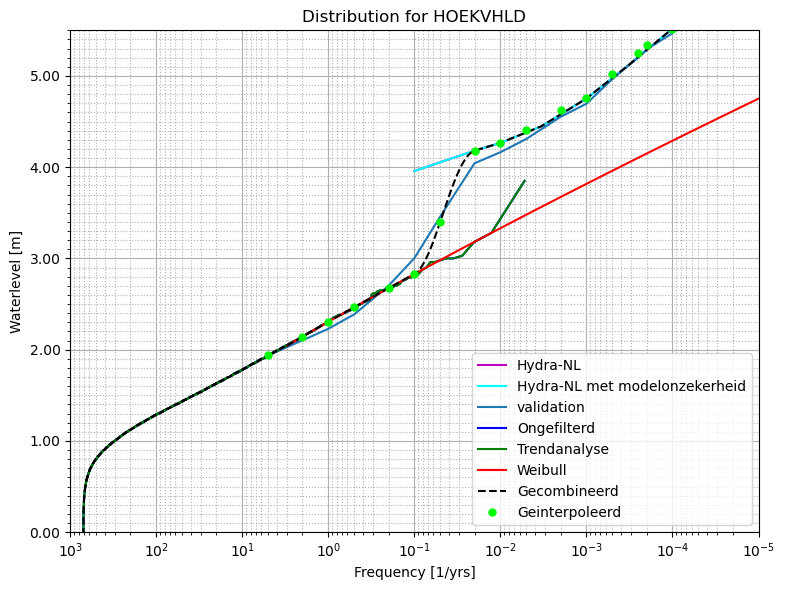

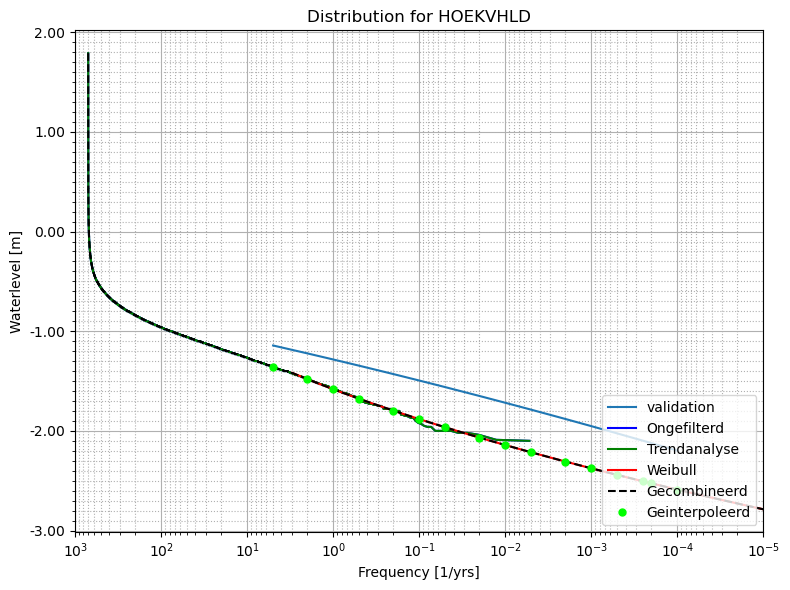

In [106]:

        # 1. Exceedance
        dist_exc = kw.calc_overschrijding(df_ext=data_pd_measext, rule_type=None, rule_value=None, 
                                          clip_physical_break=True, dist=dist_vali_exc,
                                          interp_freqs=Tfreqs_interested)
        df_interp = dist_exc['Geinterpoleerd']
        df_interp.to_csv(os.path.join(dir_overschrijding, f'Exceedance_{current_station}.csv'), index=False, sep=';')
        
        fig, ax = kw.plot_overschrijding(dist_exc)
        ax.set_ylim(0,5.5)
        fig.savefig(os.path.join(dir_overschrijding, f'Exceedance_lines_{current_station}.png'))
        
        # 2. Deceedance
        dist_dec = kw.calc_overschrijding(df_ext=data_pd_measext, rule_type=None, rule_value=None, 
                                          clip_physical_break=True, dist=dist_vali_dec, inverse=True,
                                          interp_freqs=Tfreqs_interested)
        df_interp = dist_dec['Geinterpoleerd']
        df_interp.to_csv(os.path.join(dir_overschrijding, f'Deceedance_{current_station}.csv'), index=False, sep=';')
        
        fig, ax = kw.plot_overschrijding(dist_dec)
        fig.savefig(os.path.join(dir_overschrijding, f'Deceedance_lines_{current_station}.png'))